# Behavioral Segmentation of Banking Cardholders

**Author:** Nurlyssultan Sabitov  
**Date:** May 2025  
**Project:** Hackathon – AI in Card Transactions  
**Team:** Nomad AI 
**Notebook Version:** v1.0  
**Environment:** Python 3.10, Jupyter Notebook, Scikit-learn

transaction_id - Уникальный идентификатор транзакции (UUID)

transaction_timestamp - Дата и время проведения операции (формат YYYY-MM-DD HH:MM:SS)

card _id - Внутренний числовой идентификатор карты

expiry_date - Срок действия карты в формате MM/YY

issuer_bank_name - Название банка-эмитента карты

merchant_id - Идентификатор торговой точки или

поставщика услуг (если применимо, может быть пустым для автоматических операций, таких как Salary)

merchant_mcc - Код MCC (Merchant Category Code)

торговой точки - числовой код категории бизнеса

merchant_city - Город, в котором расположена торговая точка (может быть пустым для некоторых \card _id)

In [187]:
# Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px  # Optional, for interactive plots

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from umap import UMAP  

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# clustering algorithms, ML metrics and optimization
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, OPTICS, AffinityPropagation, Birch, AgglomerativeClustering, \
                            SpectralClustering, MeanShift
from scipy.cluster import hierarchy
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
# from kneed import KneeLocator

from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from scipy.stats import entropy  

import datetime as dt

from transformers import AutoTokenizer, AutoModel
import torch

from pyod.models.ecod import ECOD

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore') 

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_parquet(f'DECENTRATHON_3.0.parquet')

In [3]:
data.head()

,transaction_id,transaction_timestamp,card_id,expiry_date,issuer_bank_name,merchant_id,merchant_mcc,mcc_category,merchant_city,transaction_type,transaction_amount_kzt,original_amount,transaction_currency,acquirer_country_iso,pos_entry_mode,wallet_type
0,ffb21bbd-fef1-4983-9774-3b01c8fc2537,2023-08-12 23:14:19.043176,10000,09/26,My Favorite Bank,50359,5499,Grocery & Food Markets,Shymkent,POS,1237.66,<NA>,KZT,KAZ,Contactless,Apple Pay
1,acd754f9-bd4c-416d-babc-926050ffe8c4,2023-08-12 17:07:08.641030,10000,09/26,My Favorite Bank,50359,5499,Grocery & Food Markets,Shymkent,POS,2328.03,<NA>,KZT,KAZ,QR_Code,Bank's QR
2,b023697b-eb35-40e6-af75-3586c60acbfb,2023-08-12 08:45:32.946846,10000,09/26,My Favorite Bank,50214,4814,Utilities & Bill Payments,Almaty,BILL_PAYMENT,53871.78,<NA>,KZT,KAZ,<NA>,<NA>
3,d59d8537-1e48-41b5-91e1-dc7cf9d0c776,2023-08-12 10:20:20.242510,10000,09/26,My Favorite Bank,50279,8011,Pharmacies & Health,Shymkent,POS,22501.56,<NA>,KZT,KAZ,Contactless,Apple Pay
4,85d2eef6-3b09-47a6-987f-f45ab491282f,2023-08-12 00:42:00.556252,10000,09/26,My Favorite Bank,50332,5499,Grocery & Food Markets,Almaty,POS,1224.04,<NA>,KZT,KAZ,QR_Code,Bank's QR


In [4]:
# cause there is only one issuer bank name, we can drop this column
data.drop(columns=['issuer_bank_name'], inplace=True)

In [5]:
iso_to_country = {
    "KAZ": "Kazakhstan",
    "TUR": "Turkey",
    "CHN": "China",
    "ARE": "United Arab Emirates",
    "ARM": "Armenia",
    "BLR": "Belarus",
    "KGZ": "Kyrgyzstan",
    "UZB": "Uzbekistan",
    "USA": "United States",
    "GEO": "Georgia",
    "ITA": "Italy"
}

data['acquirer_country_name'] = data['acquirer_country_iso'].map(iso_to_country)
data.drop(columns=['acquirer_country_iso'], inplace=True)

In [6]:
data['currency'] = data['transaction_amount_kzt'] / data['original_amount']

In [7]:
# Data Preprocessing Timestamp
data['transaction_timestamp'] = pd.to_datetime(data['transaction_timestamp'])
data['date'] = data['transaction_timestamp'].dt.date
data['hour'] = data['transaction_timestamp'].dt.hour
data['hour_category'] = pd.cut(
    data['hour'], 
    bins=[-1, 5, 11, 17, 19, 23], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening', 'Night'], 
    right=True, 
    ordered=False
)
data['weekday'] = data['transaction_timestamp'].dt.weekday
data['day'] = data['transaction_timestamp'].dt.day
data['month'] = data['transaction_timestamp'].dt.month
data['year'] = data['transaction_timestamp'].dt.year
data['day_of_year'] = data['transaction_timestamp'].dt.dayofyear
data['week_of_year'] = data['transaction_timestamp'].dt.isocalendar().week
data['day_of_week'] = data['transaction_timestamp'].dt.dayofweek
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)
data['is_weekday'] = data['weekday'].apply(lambda x: 1 if x < 5 else 0)
data['is_workday'] = data['is_weekday'].apply(lambda x: 1 if x == 1 else 0)
data['is_holiday'] = data['date'].apply(lambda x: 1 if x in ['2023-01-01', '2023-12-25'] else 0)  # Example holidays

In [8]:
categorical_columns = data.select_dtypes(include=['string']).columns
numeric_columns = data.select_dtypes(include=['number']).columns

In [11]:
categorical_columns = ['mcc_category', 'merchant_city',
       'transaction_type', 'transaction_currency', 'acquirer_country_name','merchant_mcc',
       'pos_entry_mode', 'wallet_type',
       'hour', 'weekday', 'day', 'month',
       'year', 'day_of_year', 'week_of_year', 'day_of_week', 'is_weekend',
       'is_weekday', 'is_workday', 'is_holiday'
       ]

numeric_columns = ['transaction_amount_kzt','currency','original_amount']

In [22]:
unique_cat_data = {}
for col in categorical_columns:
    unique_cat_data[col] = data[col].unique()

In [ ]:
# Data Preprocessing and Feature Engineering from transaction data 
# based on the ration and entropy of categories

def safe_entropy(series):
    counts = series.value_counts(normalize=True)
    return entropy(counts) if not counts.empty else 0

def category_ratio(series, category):
    return (series == category).mean()

def top_n_category_ratio(df, col, amt_col, n=3):
    top_vals = df[col].value_counts().nlargest(n).index
    top_amt = df[df[col].isin(top_vals)][amt_col].sum()
    total_amt = df[amt_col].sum()
    return top_amt / total_amt if total_amt > 0 else 0

# Group data by card_id
grouped = data.groupby('card_id')

# Build metrics DataFrame
segmentation_metrics = pd.DataFrame({
    # Basic spending
    'txn_count': grouped['transaction_id'].count(),
    'total_spent': grouped['transaction_amount_kzt'].sum(),
    'avg_spent': grouped['transaction_amount_kzt'].mean(),
    'std_spent': grouped['transaction_amount_kzt'].std(),
    'max_spent': grouped['transaction_amount_kzt'].max(),
    'active_days': grouped['date'].nunique(),
    'txn_per_day': grouped['transaction_id'].count() / (grouped['date'].nunique() + 1e-9),

    # POS / wallet use
    'contactless_ratio': grouped['pos_entry_mode'].apply(lambda x: category_ratio(x, 'Contactless')),
    'qr_ratio': grouped['pos_entry_mode'].apply(lambda x: category_ratio(x, 'QR_Code')),
    'wallet_used_ratio': grouped['wallet_type'].apply(lambda x: x.notna().mean()),
    'wallet_type_count': grouped['wallet_type'].nunique(),

    # Transaction type ratios
    'atm_ratio': grouped['transaction_type'].apply(lambda x: category_ratio(x, 'ATM_WITHDRAWAL')),
    'ecom_ratio': grouped['transaction_type'].apply(lambda x: category_ratio(x, 'ECOM')),
    'pos_ratio': grouped['transaction_type'].apply(lambda x: category_ratio(x, 'POS')),
    'p2p_out_ratio': grouped['transaction_type'].apply(lambda x: category_ratio(x, 'P2P_OUT')),
    'salary_ratio': grouped['transaction_type'].apply(lambda x: category_ratio(x, 'SALARY')),

    # Time behavior
    'weekday_ratio': grouped['day_of_week'].apply(lambda x: (x < 5).mean()),
    'weekend_ratio': grouped['is_weekend'].mean(),
    'night_ratio': grouped['hour'].apply(lambda x: ((x < 6) | (x >= 22)).mean()),
    'morning_ratio': grouped['hour'].apply(lambda x: ((x >= 6) & (x < 12)).mean()),
    'evening_ratio': grouped['hour'].apply(lambda x: ((x >= 18) & (x < 22)).mean()),

    # City behavior
    'unique_cities': grouped['merchant_city'].nunique(),
    'city_entropy': grouped['merchant_city'].apply(safe_entropy),
    'top_city_ratio': grouped.apply(lambda x: category_ratio(x['merchant_city'], x['merchant_city'].mode().iloc[0]) if not x['merchant_city'].mode().empty else 0),
    'top3_city_spent_ratio': grouped.apply(lambda x: top_n_category_ratio(x, 'merchant_city', 'transaction_amount_kzt')),

    # Country behavior
    'unique_countries': grouped['acquirer_country_name'].nunique(),
    'foreign_txn_ratio': grouped['acquirer_country_name'].apply(lambda x: (x != 'Kazakhstan').mean()),
    'country_entropy': grouped['acquirer_country_name'].apply(safe_entropy),
    'top_country_ratio': grouped.apply(lambda x: category_ratio(x['acquirer_country_name'], x['acquirer_country_name'].mode().iloc[0]) if not x['acquirer_country_name'].mode().empty else 0),
    'top3_country_spent_ratio': grouped.apply(lambda x: top_n_category_ratio(x, 'acquirer_country_name', 'transaction_amount_kzt')),

    # MCC behavior
    'unique_mcc_cat': grouped['mcc_category'].nunique(),
    'mcc_entropy': grouped['mcc_category'].apply(safe_entropy),
    'top_mcc_ratio': grouped.apply(lambda x: category_ratio(x['mcc_category'], x['mcc_category'].mode().iloc[0]) if not x['mcc_category'].mode().empty else 0),
    'top3_mcc_spent_ratio': grouped.apply(lambda x: top_n_category_ratio(x, 'mcc_category', 'transaction_amount_kzt')),

    # Currency behavior
    'unique_currencies': grouped['transaction_currency'].nunique(),
    'currency_entropy': grouped['transaction_currency'].apply(safe_entropy),
    'foreign_currency_ratio': grouped['transaction_currency'].apply(lambda x: (x != 'KZT').mean()),

    # Recency
    'days_since_last_txn': (pd.to_datetime("2025-01-01") - grouped['transaction_timestamp'].max()).dt.days
}).fillna(0).reset_index()


In [ ]:
# Cat columns in the form of targeted metrics of unique values

cat_columns = [
    'mcc_category', 'merchant_city', 'transaction_type',
    'transaction_currency', 'acquirer_country_name',
    'pos_entry_mode', 'wallet_type'
]

cat_metrics = []

for col in cat_columns:
    grouped_col = data.groupby(['card_id', col])['transaction_amount_kzt'].agg(
        txn_sum='sum',
        txn_count='count',
        txn_mean='mean',
        txn_std='std'
    ).reset_index()

    pivoted = grouped_col.pivot(index='card_id', columns=col)

    pivoted.columns = [f"{stat}_{col}_{str(cat).replace(' ', '_').replace('/', '_')}" 
                       for stat, cat in pivoted.columns]

    pivoted = pivoted.fillna(0)
    cat_metrics.append(pivoted)

cat_metrics_df = pd.concat(cat_metrics, axis=1).reset_index()

In [171]:
# merge segmentation metrics with category metrics

res = pd.merge(segmentation_metrics, cat_metrics_df, on='card_id', how='left')

In [172]:
res.set_index('card_id', inplace=True)

In [173]:
res.fillna(0, inplace=True)

In [168]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_res = scaler.fit_transform(res)

In [144]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Retain 95% of variance
reduced_res = pca.fit_transform(scaled_res)
print(f"Number of components retained: {pca.n_components_}")

Number of components retained: 80


# K-means based on categorical columns

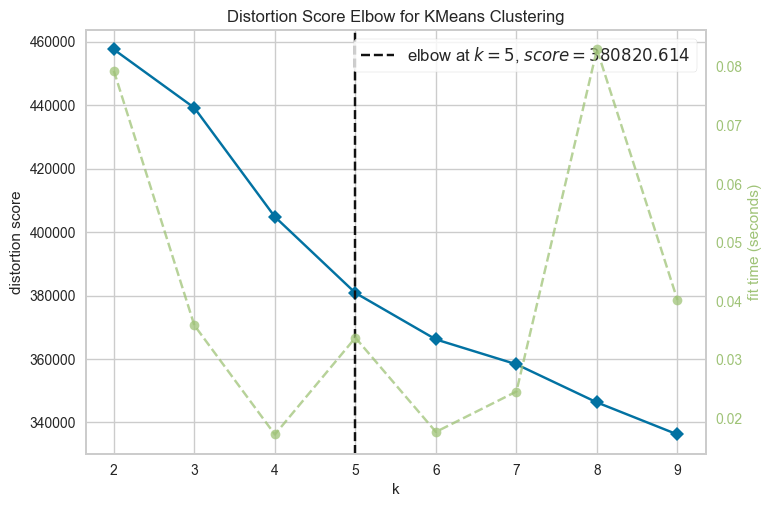

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [149]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(reduced_res)       
visualizer.show()  

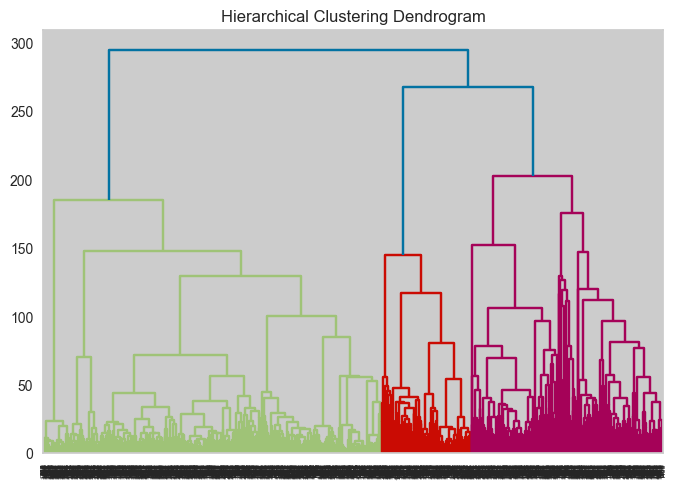

In [150]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(reduced_res, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [120]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
res['cluster'] = dbscan.fit_predict(reduced_res)

In [151]:
res['cluster'].drop_duplicates()

card_id
10000    1
10009    3
10012    0
10016    2
Name: cluster, dtype: int32

In [152]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_res, res['cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 2.356860960466718


In [153]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_res, res['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.1912406870078236


In [154]:
cluster_summary = res.groupby('cluster').mean()
print(cluster_summary)

            txn_count       total_spent     avg_spent      std_spent  \
cluster                                                                
0         5260.583535  180917306.532324  37891.122145  132633.130224   
1         2872.450213   49291663.551336  19416.644587   45232.605439   
2        18975.691176   271144458.71951  15506.381682   52368.069114   
3        10182.975962  214952017.792788  23434.351625   66436.284475   

              max_spent  active_days  txn_per_day  contactless_ratio  \
cluster                                                                
0        4662360.666804   364.825666    15.323314           0.250871   
1        1093701.941115   231.635745    15.226976           0.242326   
2           2964601.855   466.485294    41.413127           0.287450   
3         3072386.36149   450.341346    22.813037           0.178317   

         qr_ratio  wallet_used_ratio  wallet_type_count  atm_ratio  \
cluster                                                         

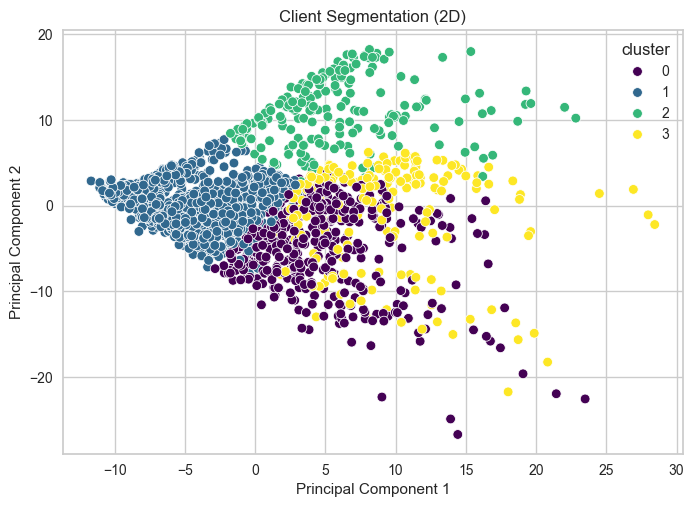

In [155]:
sns.scatterplot(
    x=reduced_res[:, 0], y=reduced_res[:, 1], hue=res['cluster'], palette='viridis'
)
plt.title('Client Segmentation (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

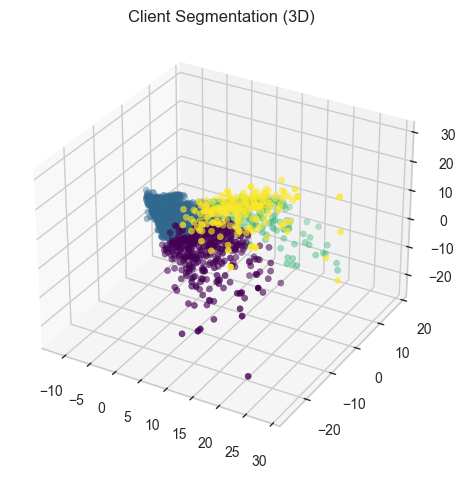

In [156]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_res[:, 0], reduced_res[:, 1], reduced_res[:, 2], c=res['cluster'], cmap='viridis')
plt.title('Client Segmentation (3D)')
plt.show()

In [159]:
# based on these results
# let's power up our k-means with additional parameter localized to Transformer 

In [162]:
res.iloc[0].to_excel(f'client_segmentation.xlsx', index=True)

In [163]:
def compile_full_profile(x):
    text_lines = []

    for col, value in x.items():
        # Format numerical values depending on type
        if isinstance(value, float):
            formatted = f"{col.replace('_', ' ')}: {round(value, 4)}"
        elif isinstance(value, int):
            formatted = f"{col.replace('_', ' ')}: {value}"
        else:
            formatted = f"{col.replace('_', ' ')}: {value}"

        text_lines.append(formatted)

    return "\n".join(text_lines)

In [179]:
sentences = res.apply(lambda x: compile_full_profile(x), axis=1).tolist()

In [184]:
client_id = res.index

In [185]:
df = pd.DataFrame({'client_id': client_id, 'profile': sentences})

In [188]:
# Load transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [195]:
profile_embedding = df['profile'].apply(lambda x: model.encode(sentences=x, normalize_embeddings  = True)).tolist()

In [204]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(profile_embedding)

In [205]:
# Find best number of clusters
scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

In [206]:
best_k = np.argmax(scores) + 2
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [215]:
best_k

np.int64(3)

In [211]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

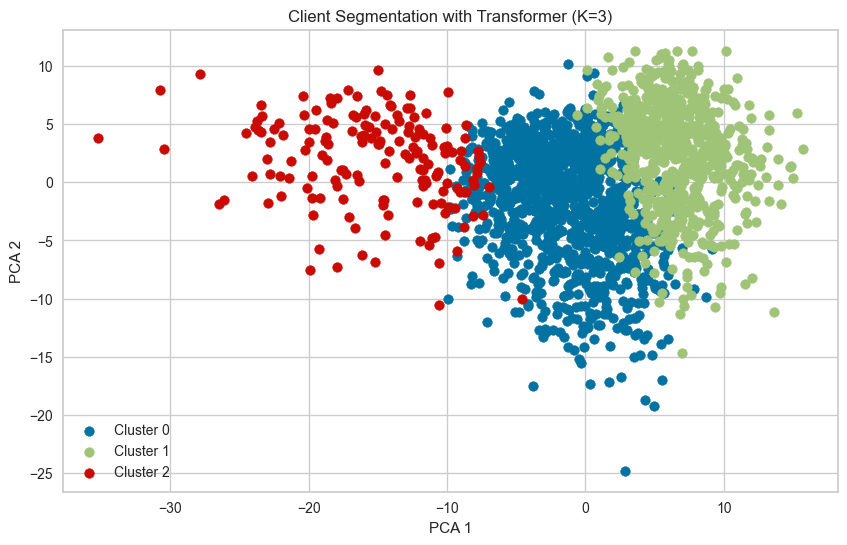

In [212]:
# Plot
plt.figure(figsize=(10, 6))
for label in df['cluster'].unique():
    subset = df[df['cluster'] == label]
    plt.scatter(subset['pca1'], subset['pca2'], label=f"Cluster {label}")
plt.title(f"Client Segmentation with Transformer (K={best_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

In [213]:
df

,client_id,profile,cluster,pca1,pca2
0,10000,txn count: 7955.0\ntotal spent: 170335602.51\n...,0,1.372285,-3.204630
1,10001,txn count: 850.0\ntotal spent: 28763166.49\nav...,0,-1.374338,2.071998
2,10002,txn count: 1731.0\ntotal spent: 19637670.01\na...,0,-0.148363,-6.550997
3,10003,txn count: 4852.0\ntotal spent: 21464554.04\na...,0,1.444989,-8.909238
4,10004,txn count: 353.0\ntotal spent: 9788625.41\navg...,0,0.021702,2.241556
...,...,...,...,...,...
1995,11995,txn count: 735.0\ntotal spent: 10253175.01\nav...,2,-23.425347,6.616436
1996,11996,txn count: 19162.0\ntotal spent: 453063362.57\...,0,-4.253013,-1.719188
1997,11997,txn count: 4480.0\ntotal spent: 75230793.67\na...,1,10.483877,0.179149
1998,11998,txn count: 4666.0\ntotal spent: 136912175.3\na...,0,-0.952180,4.148795


In [214]:
res

,txn_count,total_spent,avg_spent,std_spent,max_spent,active_days,txn_per_day,contactless_ratio,qr_ratio,wallet_used_ratio,wallet_type_count,atm_ratio,ecom_ratio,pos_ratio,p2p_out_ratio,salary_ratio,weekday_ratio,weekend_ratio,night_ratio,morning_ratio,evening_ratio,unique_cities,city_entropy,top_city_ratio,top3_city_spent_ratio,unique_countries,foreign_txn_ratio,country_entropy,top_country_ratio,top3_country_spent_ratio,unique_mcc_cat,mcc_entropy,top_mcc_ratio,top3_mcc_spent_ratio,unique_currencies,currency_entropy,foreign_currency_ratio,days_since_last_txn,txn_sum_mcc_category_Clothing_&_Apparel,txn_sum_mcc_category_Dining_&_Restaurants,txn_sum_mcc_category_Electronics_&_Software,txn_sum_mcc_category_Fuel_&_Service_Stations,txn_sum_mcc_category_General_Retail_&_Department,txn_sum_mcc_category_Grocery_&_Food_Markets,"txn_sum_mcc_category_Hobby,_Books,_Sporting_Goods",txn_sum_mcc_category_Home_Furnishings_&_Supplies,txn_sum_mcc_category_Pharmacies_&_Health,txn_sum_mcc_category_Services_(Other),txn_sum_mcc_category_Travel_&_Transportation,txn_sum_mcc_category_Unknown,txn_sum_mcc_category_Utilities_&_Bill_Payments,txn_count_mcc_category_Clothing_&_Apparel,txn_count_mcc_category_Dining_&_Restaurants,txn_count_mcc_category_Electronics_&_Software,txn_count_mcc_category_Fuel_&_Service_Stations,txn_count_mcc_category_General_Retail_&_Department,txn_count_mcc_category_Grocery_&_Food_Markets,"txn_count_mcc_category_Hobby,_Books,_Sporting_Goods",txn_count_mcc_category_Home_Furnishings_&_Supplies,txn_count_mcc_category_Pharmacies_&_Health,txn_count_mcc_category_Services_(Other),txn_count_mcc_category_Travel_&_Transportation,txn_count_mcc_category_Unknown,txn_count_mcc_category_Utilities_&_Bill_Payments,txn_mean_mcc_category_Clothing_&_Apparel,txn_mean_mcc_category_Dining_&_Restaurants,txn_mean_mcc_category_Electronics_&_Software,txn_mean_mcc_category_Fuel_&_Service_Stations,txn_mean_mcc_category_General_Retail_&_Department,txn_mean_mcc_category_Grocery_&_Food_Markets,"txn_mean_mcc_category_Hobby,_Books,_Sporting_Goods",txn_mean_mcc_category_Home_Furnishings_&_Supplies,txn_mean_mcc_category_Pharmacies_&_Health,txn_mean_mcc_category_Services_(Other),txn_mean_mcc_category_Travel_&_Transportation,txn_mean_mcc_category_Unknown,txn_mean_mcc_category_Utilities_&_Bill_Payments,txn_std_mcc_category_Clothing_&_Apparel,txn_std_mcc_category_Dining_&_Restaurants,txn_std_mcc_category_Electronics_&_Software,txn_std_mcc_category_Fuel_&_Service_Stations,txn_std_mcc_category_General_Retail_&_Department,txn_std_mcc_category_Grocery_&_Food_Markets,"txn_std_mcc_category_Hobby,_Books,_Sporting_Goods",txn_std_mcc_category_Home_Furnishings_&_Supplies,txn_std_mcc_category_Pharmacies_&_Health,txn_std_mcc_category_Services_(Other),txn_std_mcc_category_Travel_&_Transportation,txn_std_mcc_category_Unknown,txn_std_mcc_category_Utilities_&_Bill_Payments,txn_sum_merchant_city_Aktobe,txn_sum_merchant_city_Almaty,txn_sum_merchant_city_Astana,txn_sum_merchant_city_Karaganda,txn_sum_merchant_city_Other,txn_sum_merchant_city_Shymkent,txn_sum_merchant_city_Unknown,txn_count_merchant_city_Aktobe,txn_count_merchant_city_Almaty,txn_count_merchant_city_Astana,txn_count_merchant_city_Karaganda,txn_count_merchant_city_Other,txn_count_merchant_city_Shymkent,txn_count_merchant_city_Unknown,txn_mean_merchant_city_Aktobe,txn_mean_merchant_city_Almaty,txn_mean_merchant_city_Astana,txn_mean_merchant_city_Karaganda,txn_mean_merchant_city_Other,txn_mean_merchant_city_Shymkent,txn_mean_merchant_city_Unknown,txn_std_merchant_city_Aktobe,txn_std_merchant_city_Almaty,txn_std_merchant_city_Astana,txn_std_merchant_city_Karaganda,txn_std_merchant_city_Other,txn_std_merchant_city_Shymkent,txn_std_merchant_city_Unknown,txn_sum_transaction_type_ATM_WITHDRAWAL,txn_sum_transaction_type_BILL_PAYMENT,txn_sum_transaction_type_ECOM,txn_sum_transaction_type_P2P_IN,txn_sum_transaction_type_P2P_OUT,txn_sum_transaction_type_POS,txn_sum_transaction_type_SALARY,txn_sum_transaction_type_Unknown,txn_count_transac

In [216]:
df

,client_id,profile,cluster,pca1,pca2
0,10000,txn count: 7955.0\ntotal spent: 170335602.51\n...,0,1.372285,-3.204630
1,10001,txn count: 850.0\ntotal spent: 28763166.49\nav...,0,-1.374338,2.071998
2,10002,txn count: 1731.0\ntotal spent: 19637670.01\na...,0,-0.148363,-6.550997
3,10003,txn count: 4852.0\ntotal spent: 21464554.04\na...,0,1.444989,-8.909238
4,10004,txn count: 353.0\ntotal spent: 9788625.41\navg...,0,0.021702,2.241556
...,...,...,...,...,...
1995,11995,txn count: 735.0\ntotal spent: 10253175.01\nav...,2,-23.425347,6.616436
1996,11996,txn count: 19162.0\ntotal spent: 453063362.57\...,0,-4.253013,-1.719188
1997,11997,txn count: 4480.0\ntotal spent: 75230793.67\na...,1,10.483877,0.179149
1998,11998,txn count: 4666.0\ntotal spent: 136912175.3\na...,0,-0.952180,4.148795


In [217]:
res

,txn_count,total_spent,avg_spent,std_spent,max_spent,active_days,txn_per_day,contactless_ratio,qr_ratio,wallet_used_ratio,wallet_type_count,atm_ratio,ecom_ratio,pos_ratio,p2p_out_ratio,salary_ratio,weekday_ratio,weekend_ratio,night_ratio,morning_ratio,evening_ratio,unique_cities,city_entropy,top_city_ratio,top3_city_spent_ratio,unique_countries,foreign_txn_ratio,country_entropy,top_country_ratio,top3_country_spent_ratio,unique_mcc_cat,mcc_entropy,top_mcc_ratio,top3_mcc_spent_ratio,unique_currencies,currency_entropy,foreign_currency_ratio,days_since_last_txn,txn_sum_mcc_category_Clothing_&_Apparel,txn_sum_mcc_category_Dining_&_Restaurants,txn_sum_mcc_category_Electronics_&_Software,txn_sum_mcc_category_Fuel_&_Service_Stations,txn_sum_mcc_category_General_Retail_&_Department,txn_sum_mcc_category_Grocery_&_Food_Markets,"txn_sum_mcc_category_Hobby,_Books,_Sporting_Goods",txn_sum_mcc_category_Home_Furnishings_&_Supplies,txn_sum_mcc_category_Pharmacies_&_Health,txn_sum_mcc_category_Services_(Other),txn_sum_mcc_category_Travel_&_Transportation,txn_sum_mcc_category_Unknown,txn_sum_mcc_category_Utilities_&_Bill_Payments,txn_count_mcc_category_Clothing_&_Apparel,txn_count_mcc_category_Dining_&_Restaurants,txn_count_mcc_category_Electronics_&_Software,txn_count_mcc_category_Fuel_&_Service_Stations,txn_count_mcc_category_General_Retail_&_Department,txn_count_mcc_category_Grocery_&_Food_Markets,"txn_count_mcc_category_Hobby,_Books,_Sporting_Goods",txn_count_mcc_category_Home_Furnishings_&_Supplies,txn_count_mcc_category_Pharmacies_&_Health,txn_count_mcc_category_Services_(Other),txn_count_mcc_category_Travel_&_Transportation,txn_count_mcc_category_Unknown,txn_count_mcc_category_Utilities_&_Bill_Payments,txn_mean_mcc_category_Clothing_&_Apparel,txn_mean_mcc_category_Dining_&_Restaurants,txn_mean_mcc_category_Electronics_&_Software,txn_mean_mcc_category_Fuel_&_Service_Stations,txn_mean_mcc_category_General_Retail_&_Department,txn_mean_mcc_category_Grocery_&_Food_Markets,"txn_mean_mcc_category_Hobby,_Books,_Sporting_Goods",txn_mean_mcc_category_Home_Furnishings_&_Supplies,txn_mean_mcc_category_Pharmacies_&_Health,txn_mean_mcc_category_Services_(Other),txn_mean_mcc_category_Travel_&_Transportation,txn_mean_mcc_category_Unknown,txn_mean_mcc_category_Utilities_&_Bill_Payments,txn_std_mcc_category_Clothing_&_Apparel,txn_std_mcc_category_Dining_&_Restaurants,txn_std_mcc_category_Electronics_&_Software,txn_std_mcc_category_Fuel_&_Service_Stations,txn_std_mcc_category_General_Retail_&_Department,txn_std_mcc_category_Grocery_&_Food_Markets,"txn_std_mcc_category_Hobby,_Books,_Sporting_Goods",txn_std_mcc_category_Home_Furnishings_&_Supplies,txn_std_mcc_category_Pharmacies_&_Health,txn_std_mcc_category_Services_(Other),txn_std_mcc_category_Travel_&_Transportation,txn_std_mcc_category_Unknown,txn_std_mcc_category_Utilities_&_Bill_Payments,txn_sum_merchant_city_Aktobe,txn_sum_merchant_city_Almaty,txn_sum_merchant_city_Astana,txn_sum_merchant_city_Karaganda,txn_sum_merchant_city_Other,txn_sum_merchant_city_Shymkent,txn_sum_merchant_city_Unknown,txn_count_merchant_city_Aktobe,txn_count_merchant_city_Almaty,txn_count_merchant_city_Astana,txn_count_merchant_city_Karaganda,txn_count_merchant_city_Other,txn_count_merchant_city_Shymkent,txn_count_merchant_city_Unknown,txn_mean_merchant_city_Aktobe,txn_mean_merchant_city_Almaty,txn_mean_merchant_city_Astana,txn_mean_merchant_city_Karaganda,txn_mean_merchant_city_Other,txn_mean_merchant_city_Shymkent,txn_mean_merchant_city_Unknown,txn_std_merchant_city_Aktobe,txn_std_merchant_city_Almaty,txn_std_merchant_city_Astana,txn_std_merchant_city_Karaganda,txn_std_merchant_city_Other,txn_std_merchant_city_Shymkent,txn_std_merchant_city_Unknown,txn_sum_transaction_type_ATM_WITHDRAWAL,txn_sum_transaction_type_BILL_PAYMENT,txn_sum_transaction_type_ECOM,txn_sum_transaction_type_P2P_IN,txn_sum_transaction_type_P2P_OUT,txn_sum_transaction_type_POS,txn_sum_transaction_type_SALARY,txn_sum_transaction_type_Unknown,txn_count_transac

In [218]:
input_data = pd.merge(res, df[['client_id','profile', 'cluster']], left_index=True, right_on='client_id', how='left')

In [220]:
input_data.set_index('client_id', inplace=True)

In [222]:
input_data

,txn_count,total_spent,avg_spent,std_spent,max_spent,active_days,txn_per_day,contactless_ratio,qr_ratio,wallet_used_ratio,wallet_type_count,atm_ratio,ecom_ratio,pos_ratio,p2p_out_ratio,salary_ratio,weekday_ratio,weekend_ratio,night_ratio,morning_ratio,evening_ratio,unique_cities,city_entropy,top_city_ratio,top3_city_spent_ratio,unique_countries,foreign_txn_ratio,country_entropy,top_country_ratio,top3_country_spent_ratio,unique_mcc_cat,mcc_entropy,top_mcc_ratio,top3_mcc_spent_ratio,unique_currencies,currency_entropy,foreign_currency_ratio,days_since_last_txn,txn_sum_mcc_category_Clothing_&_Apparel,txn_sum_mcc_category_Dining_&_Restaurants,txn_sum_mcc_category_Electronics_&_Software,txn_sum_mcc_category_Fuel_&_Service_Stations,txn_sum_mcc_category_General_Retail_&_Department,txn_sum_mcc_category_Grocery_&_Food_Markets,"txn_sum_mcc_category_Hobby,_Books,_Sporting_Goods",txn_sum_mcc_category_Home_Furnishings_&_Supplies,txn_sum_mcc_category_Pharmacies_&_Health,txn_sum_mcc_category_Services_(Other),txn_sum_mcc_category_Travel_&_Transportation,txn_sum_mcc_category_Unknown,txn_sum_mcc_category_Utilities_&_Bill_Payments,txn_count_mcc_category_Clothing_&_Apparel,txn_count_mcc_category_Dining_&_Restaurants,txn_count_mcc_category_Electronics_&_Software,txn_count_mcc_category_Fuel_&_Service_Stations,txn_count_mcc_category_General_Retail_&_Department,txn_count_mcc_category_Grocery_&_Food_Markets,"txn_count_mcc_category_Hobby,_Books,_Sporting_Goods",txn_count_mcc_category_Home_Furnishings_&_Supplies,txn_count_mcc_category_Pharmacies_&_Health,txn_count_mcc_category_Services_(Other),txn_count_mcc_category_Travel_&_Transportation,txn_count_mcc_category_Unknown,txn_count_mcc_category_Utilities_&_Bill_Payments,txn_mean_mcc_category_Clothing_&_Apparel,txn_mean_mcc_category_Dining_&_Restaurants,txn_mean_mcc_category_Electronics_&_Software,txn_mean_mcc_category_Fuel_&_Service_Stations,txn_mean_mcc_category_General_Retail_&_Department,txn_mean_mcc_category_Grocery_&_Food_Markets,"txn_mean_mcc_category_Hobby,_Books,_Sporting_Goods",txn_mean_mcc_category_Home_Furnishings_&_Supplies,txn_mean_mcc_category_Pharmacies_&_Health,txn_mean_mcc_category_Services_(Other),txn_mean_mcc_category_Travel_&_Transportation,txn_mean_mcc_category_Unknown,txn_mean_mcc_category_Utilities_&_Bill_Payments,txn_std_mcc_category_Clothing_&_Apparel,txn_std_mcc_category_Dining_&_Restaurants,txn_std_mcc_category_Electronics_&_Software,txn_std_mcc_category_Fuel_&_Service_Stations,txn_std_mcc_category_General_Retail_&_Department,txn_std_mcc_category_Grocery_&_Food_Markets,"txn_std_mcc_category_Hobby,_Books,_Sporting_Goods",txn_std_mcc_category_Home_Furnishings_&_Supplies,txn_std_mcc_category_Pharmacies_&_Health,txn_std_mcc_category_Services_(Other),txn_std_mcc_category_Travel_&_Transportation,txn_std_mcc_category_Unknown,txn_std_mcc_category_Utilities_&_Bill_Payments,txn_sum_merchant_city_Aktobe,txn_sum_merchant_city_Almaty,txn_sum_merchant_city_Astana,txn_sum_merchant_city_Karaganda,txn_sum_merchant_city_Other,txn_sum_merchant_city_Shymkent,txn_sum_merchant_city_Unknown,txn_count_merchant_city_Aktobe,txn_count_merchant_city_Almaty,txn_count_merchant_city_Astana,txn_count_merchant_city_Karaganda,txn_count_merchant_city_Other,txn_count_merchant_city_Shymkent,txn_count_merchant_city_Unknown,txn_mean_merchant_city_Aktobe,txn_mean_merchant_city_Almaty,txn_mean_merchant_city_Astana,txn_mean_merchant_city_Karaganda,txn_mean_merchant_city_Other,txn_mean_merchant_city_Shymkent,txn_mean_merchant_city_Unknown,txn_std_merchant_city_Aktobe,txn_std_merchant_city_Almaty,txn_std_merchant_city_Astana,txn_std_merchant_city_Karaganda,txn_std_merchant_city_Other,txn_std_merchant_city_Shymkent,txn_std_merchant_city_Unknown,txn_sum_transaction_type_ATM_WITHDRAWAL,txn_sum_transaction_type_BILL_PAYMENT,txn_sum_transaction_type_ECOM,txn_sum_transaction_type_P2P_IN,txn_sum_transaction_type_P2P_OUT,txn_sum_transaction_type_POS,txn_sum_transaction_type_SALARY,txn_sum_transaction_type_Unknown,txn_count_transac

In [ ]:
input_data.to_parquet('input_client_segmentation_with_transformer.parquet', index=False)

In [228]:
input_data[['profile', 'cluster']].reset_index().to_parquet('output_client_segmentation_with_transformer.parquet', index=False)

# End